<a href="https://colab.research.google.com/github/rara-by/nCOVnet-with-5foldCV/blob/main/TL_VGG16_25_with_5foldCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive to access data and save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prerequisites

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from keras.layers import Lambda
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, AveragePooling2D  
from tensorflow.keras.optimizers import Adam                  
from tensorflow.keras.metrics import categorical_crossentropy 
from tensorflow.keras.preprocessing import image #
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score #
import seaborn as sns  #
import itertools    
#import os
#import shutil
import random    
from glob import glob
import matplotlib.pyplot as plt
import warnings   
import cv2  #
warnings.simplefilter(action='ignore', category=FutureWarning) 
%matplotlib inline  

Load Data



In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = ''
noncovid_path = ''

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
#for i in range(5):  
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
#for i in range(10):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

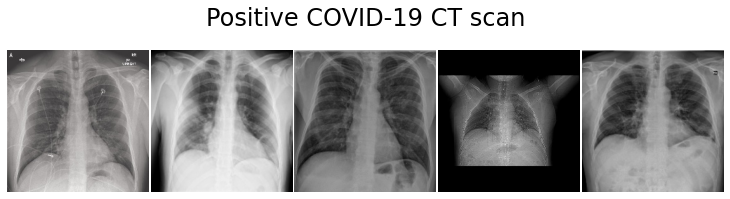

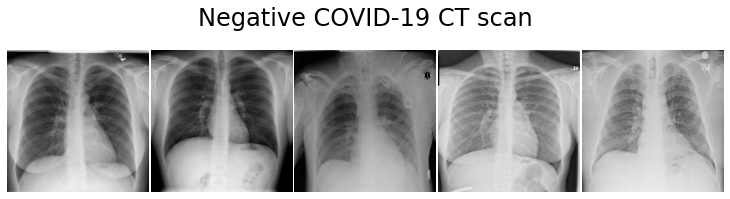

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 1, 5
    figsize = [10, 3]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT scan')
plot_images(noncovid_images, 'Negative COVID-19 CT scan')

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10


# the _junk suffix means that we drop that variable completely
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=1 - train_ratio, random_state=1)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=1 - train_ratio, random_state=1)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
covid_x_validation, covid_x_test, covid_y_validation, covid_y_test = train_test_split(
    covid_x_test, covid_y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)
noncovid_x_validation, noncovid_x_test, noncovid_y_validation, noncovid_y_test = train_test_split(
    noncovid_x_test, noncovid_y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)





X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
X_validation=np.concatenate((noncovid_x_validation, covid_x_validation), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)
y_validation = np.concatenate((noncovid_y_validation, covid_y_validation), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

y_validation = LabelBinarizer().fit_transform(y_validation)
y_validation = to_categorical(y_validation)

In [ ]:
print('train',np.shape(X_train))
print('test', np.shape(X_test))
print('validation', np.shape(X_validation))

train (740, 224, 224, 3)
test (93, 224, 224, 3)
validation (92, 224, 224, 3)


Transfer Learning

In [ ]:

# # define a new model with random weights (not pre-trained) and 10 classes
# new_input = Input(shape=(224, 224, 3))
# model = VGG16(weights=None, input_tensor=new_input, classes=10)
#input tensor = pixel scaling s done when training

In [ ]:
...
# # load model without output layer
# model = VGG16(include_top=False)

from keras.applications.vgg16 import VGG16
# load model
model = VGG16(input_shape = (224,224,3),include_top = False, weights = 'imagenet')
# summarize the model
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Custom Classification Layer

In [ ]:
classific_model = Sequential()
classific_model.add(model)
classific_model.add(AveragePooling2D(pool_size=(4, 4),strides=None, padding = 'valid'))
classific_model.add(Flatten())
classific_model.add(Dense(256, activation='relu'))
classific_model.add(Dropout(0.5))
classific_model.add(Dense(2, activation='softmax'))
classific_model.layers[0].trainable = False
classific_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
____________________________________

5 fold cross validation

In [ ]:
from sklearn.model_selection import KFold

classific_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

kfold = KFold(n_splits=5, shuffle=False, random_state=1)
cvscores = []
ray=[]
hist=[]
Score=[]
f1=[]
area=[]
recall=[]
TP=[]
TN=[]
FP=[]
FN=[]
batch_size = 32
for train, test in kfold.split(X_train,y_train):
  # Fit the model
  history = classific_model.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=80,
                    verbose=2)
  #evaluate the model
  ray.append(np.transpose(np.array([history.history['accuracy'],history.history['loss'],history.history['val_accuracy'],history.history['val_loss']])))
  hist.append(history.history)
  scores = classific_model.evaluate(X_test, y_test, verbose=0)
  Score.append(scores)
  print("%s: %.2f%%" % (classific_model.metrics_names[1], scores[1]*100))


In [ ]:
classific_model.save('VGG_96_kernel10.h5')
classific_model.save_weights('VGG_96_kernel10.hdf5')
np.save('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL/VGG_96_kernel10_history.npy',ray)
np.save('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL/VGG_96_kernel10_hist.npy',hist)

/content/drive/.shortcut-targets-by-id/1vyvXWeOJAHIn_9vVlMGLqXOIs8LU1Mgd/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL/VGG_96_kernel10.h5')
hist=np.load('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL/VGG_96_kernel10_hist.npy',allow_pickle=True)
#np.loadtxt('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/result/VGG_96_Kernel10/VGG_96_kernel10_history.txt')
ray=np.load('/content/drive/My Drive/Projects/COVID-19/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans-master/VGG16 TL/VGG_96_kernel10_history.npy',allow_pickle=True)

In [ ]:
history.history['accuracy']    =ray[4,:,0]
history.history['loss']        =ray[4,:,1]
history.history['val_accuracy']=ray[4,:,2]
history.history['val_loss']    =ray[4,:,3]

Predictions

In [ ]:
y_pred = classific_model.predict(X_test, batch_size=batch_size)

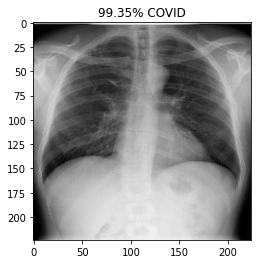

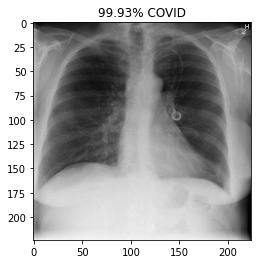

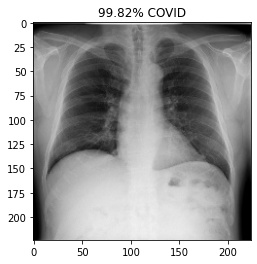

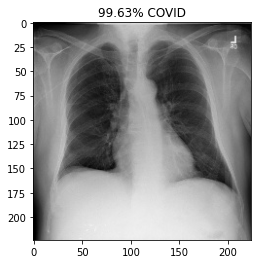

In [ ]:
prediction=y_pred[0:4]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

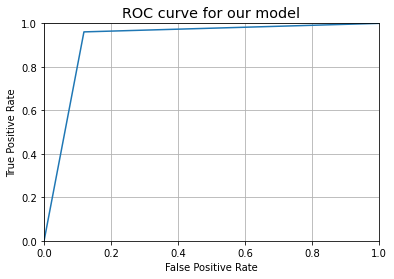

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


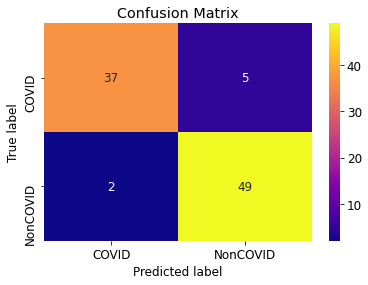

Confusion Matrix with Normalized Values


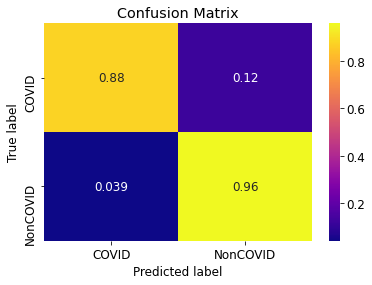

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

print('\nAUC', metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        42
           1       0.91      0.96      0.93        51

    accuracy                           0.92        93
   macro avg       0.93      0.92      0.92        93
weighted avg       0.93      0.92      0.92        93


AUC 0.9208683473389356


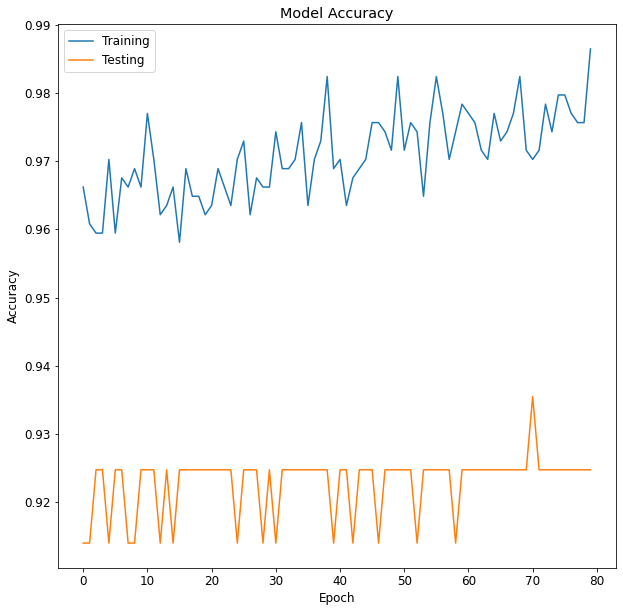

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()

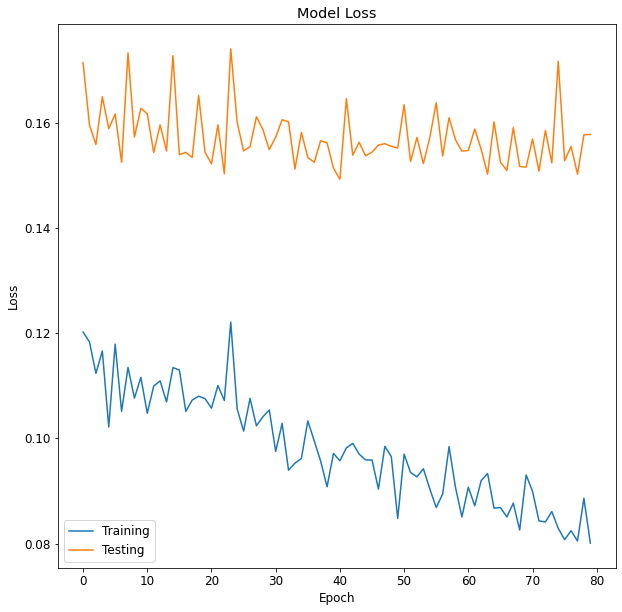

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()

VGG 16 model from scrath (foregoing transfer learning)


In [ ]:
# model = Sequential([
#     Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
#     Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
#     MaxPool2D(pool_size=(2, 2), strides=2),

#     Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
#     Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
#     MaxPool2D(pool_size=(2, 2), strides=2),

#     Conv2D(filters=256, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=256, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=256, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     MaxPool2D(pool_size=(2, 2),strides=2),

#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     MaxPool2D(pool_size=(2, 2),strides=2),

#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding = 'same'),
#     MaxPool2D(pool_size=(2, 2),strides=2),
#     AveragePooling2D(pool_size=(4, 4),strides=None, padding = 'valid'),

#     Flatten(),
#     Dense(units= 256, activation = 'relu'),
#     Dropout(0.5),
#     Dense(units=2, activation='softmax')
# ])

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# model.summary()

In [ ]:
# batch_size = 32
# history = model.fit(X_train, y_train, batch_size=batch_size,
#                     validation_data=(X_test, y_test),
#                     validation_steps=len(X_test) / batch_size,
#                     steps_per_epoch=len(X_train) / batch_size,
#                     epochs=100,
#                     verbose=2) 
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

K-fold CV

In [ ]:
# from sklearn.model_selection import KFold

# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# cvscores = []
# batch_size = 32
# for train, test in kfold.split(X_train,y_train):
# 	# Fit the model
# 	history = model.fit(X_train, y_train, batch_size=batch_size,
#                     validation_data=(X_test, y_test),
#                     validation_steps=len(X_test) / batch_size,
#                     steps_per_epoch=len(X_train) / batch_size,
#                     epochs=100,
#                     verbose=2) 
# 	#evaluate the model
# 	scores = classific_model.evaluate(X_test, y_test, verbose=0)
# 	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# 	cvscores.append(scores[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
scores

[0.1578180491924286, 0.9247311949729919]

Augmentation

In [ ]:
# train_aug = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
# )

# history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
#                     validation_data=(X_test, y_test),
#                     validation_steps=len(X_test) / 32,
#                     steps_per_epoch=len(X_train) / 32,
#                     epochs=50,
#                     verbose=2) #epochs = 500 is a good number 

Simple model fit

In [ ]:
# history = model.fit(X_train, y_train, batch_size=32,
#                     validation_data=(X_test, y_test),
#                     validation_steps=len(X_test) / 32,
#                     steps_per_epoch=len(X_train) / 32,
#                     epochs=100,
#                     verbose=2) 